# CAPM Project — Beta & Alpha Estimation (with Custom Tickers)

This notebook estimates **Beta (systematic risk)**, **Alpha (risk-adjusted excess return)**, and **R²**
for any list of stocks relative to a market index (default: S&P 500 `^GSPC`).  
It fetches historical prices via Yahoo Finance, computes daily returns, runs **OLS regressions**,
and saves a summary CSV and per-stock regression plots.

> Tip: You can either edit the `TICKERS_DEFAULT` list directly **or** enter tickers at runtime using the input cell.

In [1]:
# If packages are missing, uncomment and run:
# !pip install yfinance pandas numpy matplotlib statsmodels

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display
from datetime import datetime

plt.rcParams["figure.figsize"] = (9, 6)
TRADING_DAYS = 252

In [2]:
# Default configuration
TICKERS_DEFAULT = ["AAPL", "MSFT", "NVDA"]   # <- You can edit this list
MARKET_TICKER   = "^GSPC"                    # S&P 500 index
START_DATE      = "2022-01-01"
END_DATE        = "2025-01-01"

# Optional: annual risk-free rate (e.g., 0.05 for 5%). Set to None to skip.
RF_ANNUAL = None

In [3]:
def parse_user_tickers(defaults):
    """Read tickers from user input; allow spaces or commas. Fallback to defaults."""
    try:
        raw = input(f"Enter tickers separated by space/comma (Enter for defaults {defaults}): ").strip()
    except Exception:
        raw = ""
    if not raw:
        return defaults
    parts = [p.strip().upper() for p in raw.replace(",", " ").split() if p.strip()]
    return parts if parts else defaults

def fetch_prices(tickers, market, start, end):
    all_syms = list(set(tickers + [market]))
    raw = yf.download(all_syms, start=start, end=end, auto_adjust=True, progress=False)
    prices = raw["Close"].copy()
    return prices

def compute_returns(prices, rf_annual=None):
    rets = prices.pct_change().dropna()
    if rf_annual is None:
        return rets, None
    rf_daily = (1 + rf_annual)**(1/TRADING_DAYS) - 1
    rf_series = pd.Series(rf_daily, index=rets.index)
    return rets, rf_series

def run_capm(returns_df, market_col, rf_daily_series=None):
    market = returns_df[market_col].copy()
    results = []
    for col in returns_df.columns:
        if col == market_col:
            continue
        y = returns_df[col]
        x = market
        if rf_daily_series is not None:
            y = y - rf_daily_series
            x = x - rf_daily_series
        X = sm.add_constant(x)
        model = sm.OLS(y, X, missing='drop').fit()
        alpha = model.params.get('const', float('nan'))
        beta  = model.params.iloc[1] if len(model.params) > 1 else float('nan')
        r2    = model.rsquared
        results.append({"Ticker": col, "Alpha (daily)": alpha, "Beta": beta, "R²": r2})
    return pd.DataFrame(results).set_index("Ticker")

def plot_capm_scatter(returns_df, market_col, summary_df, rf_daily_series=None, out_dir="."):
    market = returns_df[market_col].copy()
    saved = []
    for ticker in summary_df.index:
        y = returns_df[ticker]
        x = market
        if rf_daily_series is not None:
            y = y - rf_daily_series
            x = x - rf_daily_series
        alpha = summary_df.loc[ticker, "Alpha (daily)"]
        beta  = summary_df.loc[ticker, "Beta"]
        line  = alpha + beta * x
        fig, ax = plt.subplots()
        ax.scatter(x, y, s=8, alpha=0.5)
        ax.plot(x, line, linewidth=2)
        ax.set_title(f"CAPM Regression: {ticker} vs {market_col}")
        ax.set_xlabel(f"{market_col} Daily Return")
        ax.set_ylabel(f"{ticker} Daily Return")
        plt.tight_layout()
        fname = f"{out_dir}/capm_{ticker}.png"
        fig.savefig(fname, dpi=150)
        plt.show()
        saved.append(fname)
    return saved

def annualize_alpha(alpha_daily):
    return alpha_daily * TRADING_DAYS

def pretty_summary(summary_df):
    out = summary_df.copy()
    out["Alpha (annual approx)"] = out["Alpha (daily)"].apply(annualize_alpha)
    return out[["Beta", "R²", "Alpha (daily)", "Alpha (annual approx)"]]

In [4]:
# Option A: Use defaults
tickers = TICKERS_DEFAULT.copy()

# Option B: Uncomment to type tickers at runtime
# tickers = parse_user_tickers(TICKERS_DEFAULT)

print("Using tickers:", tickers)

Using tickers: ['AAPL', 'MSFT', 'NVDA']


In [5]:
prices = fetch_prices(tickers, MARKET_TICKER, START_DATE, END_DATE)
returns, rf_daily = compute_returns(prices, RF_ANNUAL)

print("Data range:", prices.index.min().date(), "to", prices.index.max().date())
display(returns.head())

Data range: 2022-01-03 to 2024-12-31


Ticker,AAPL,MSFT,NVDA,^GSPC
Date,,,,
2022-01-04,-0.012692,-0.017147,-0.027589,-0.000630
2022-01-05,-0.026600,-0.038388,-0.057562,-0.019393
2022-01-06,-0.016693,-0.007902,0.020794,-0.000964
2022-01-07,0.000988,0.000510,-0.033040,-0.004050
2022-01-10,0.000116,0.000732,0.005615,-0.001441


In [6]:
summary = run_capm(returns, MARKET_TICKER, rf_daily)
pretty = pretty_summary(summary).round(6)
display(pretty)

,Beta,R²,Alpha (daily),Alpha (annual approx)
Ticker,,,,
AAPL,1.210689,0.611444,0.000189,0.047683
MSFT,1.248328,0.627477,0.000077,0.019360
NVDA,2.268516,0.515835,0.001835,0.462472


In [7]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
summary_path = f"beta_summary_{timestamp}.csv"
pretty.to_csv(summary_path)
print(f"Saved summary: {summary_path}")

Saved summary: beta_summary_20251110_070730.csv


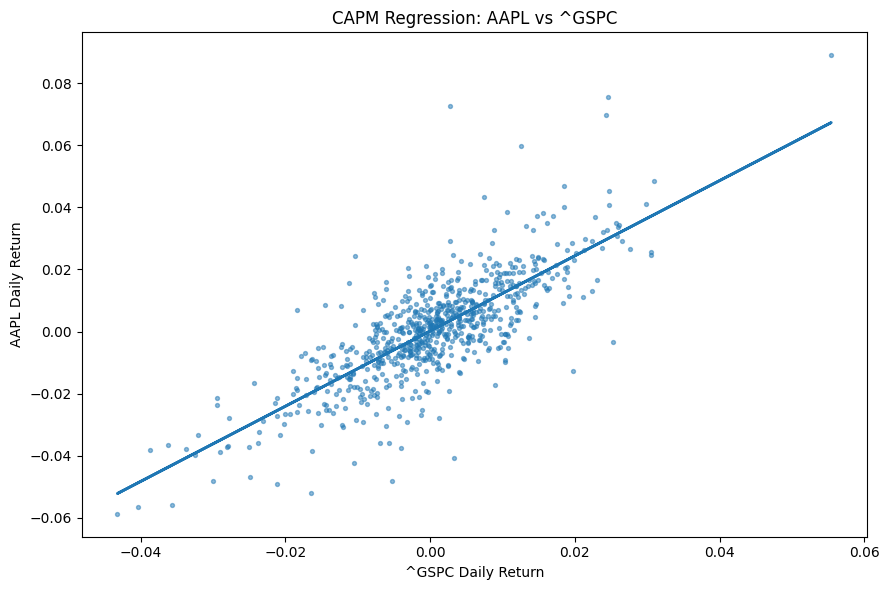

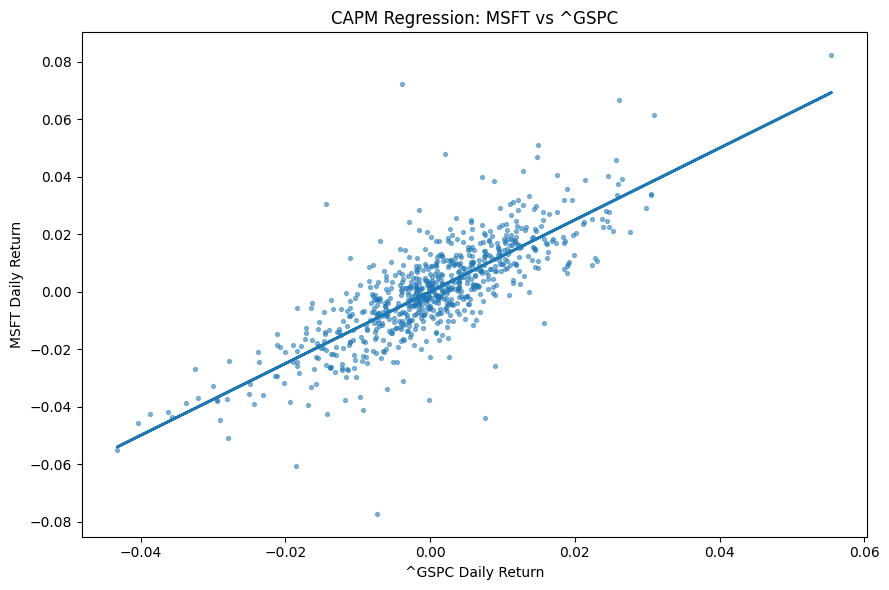

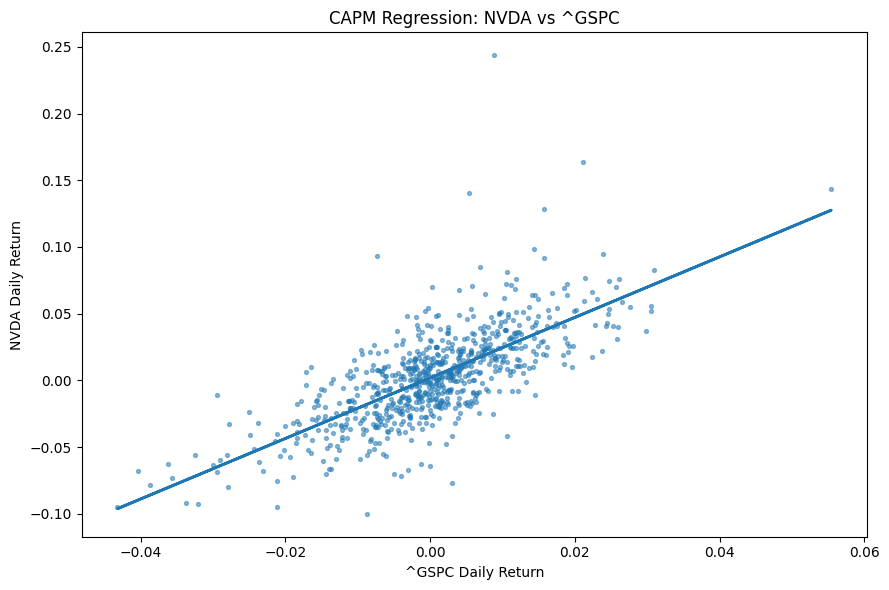

Saved plots: ['./capm_AAPL.png', './capm_MSFT.png', './capm_NVDA.png']


In [8]:
saved_files = plot_capm_scatter(returns, MARKET_TICKER, summary, rf_daily, out_dir=".")
print("Saved plots:", saved_files)

- **Beta > 1** → Stock moves more than the market (higher volatility).
- **Beta < 1** → Stock is defensive (moves less than market).
- **Alpha (annual approx)** → Positive = outperformance; Negative = underperformance.
- **R²** → Proportion of stock movement explained by market.

Try adjusting:
- `START_DATE` and `END_DATE` to change the sample period
- `MARKET_TICKER` to analyze against other benchmarks (e.g., `^NDX` for NASDAQ).